# Baseline Model - Regime-Aware Volatility

We established:
- Log returns are approximately stationary
- Volatility clustering is present
- Market behavior is not structurally constant over long horizons

This notebook focus is on statistical model for volatility forecasting, and regime shift estimation. 

## Setup & Import

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# model

from arch import arch_model

In [5]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from dataclasses import dataclass, asdict
from typing import Optional, Dict, Any

In [6]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Preparation

In [8]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
print("are dates sorted?:", df.index.is_monotonic_increasing)

are dates sorted?: True


In [9]:
df_train, df_test = train_test_split(df, shuffle=False, train_size=0.8)

In [10]:
# is variance modeling actually needed?
std_resid = StandardScaler().fit_transform(df[['LogReturn']].dropna())
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=12)
print("ARCH test on std resid p-value:", lm_pvalue)

ARCH test on std resid p-value: 2.234273377186347e-112


ARCH LM null hypothesis assume all coffiecient including the constant is 0. 
p <<< 0.05 conforms that volatility clusters and varying conditional volatility.

## Model Building

In [11]:
# target window
TARGET = 1 # in days

# scaling for numeric stability 
r_pct = df['LogReturn'].dropna() * 100 

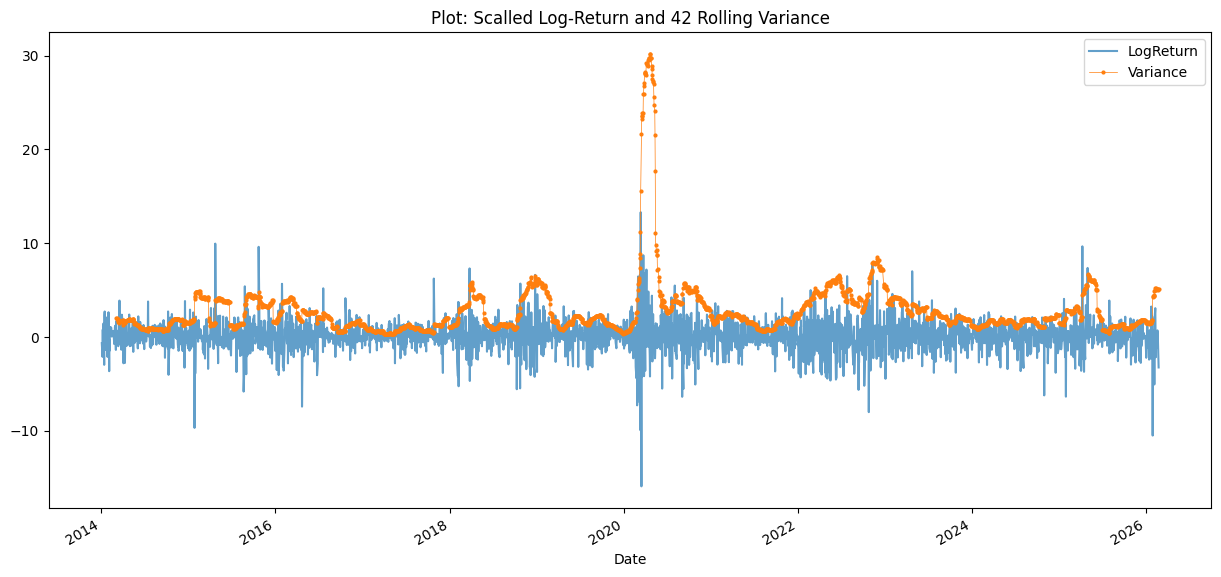

In [12]:
roll = 42
plt.figure(figsize=(15, 7))
(r_pct).plot(legend=True, alpha=0.7)
#(r_pct ** 2).plot(legend=True, label='variance')
(r_pct).rolling(roll).var().plot(legend=True, label='Variance', 
                               marker='o', markersize=2, linewidth=0.5)
plt.title(f"Plot: Scalled Log-Return and {roll} Rolling Variance")
plt.show()

GARCH might perform better.

In [13]:
np.round(r_pct.mean(), 4)

np.float64(0.0828)

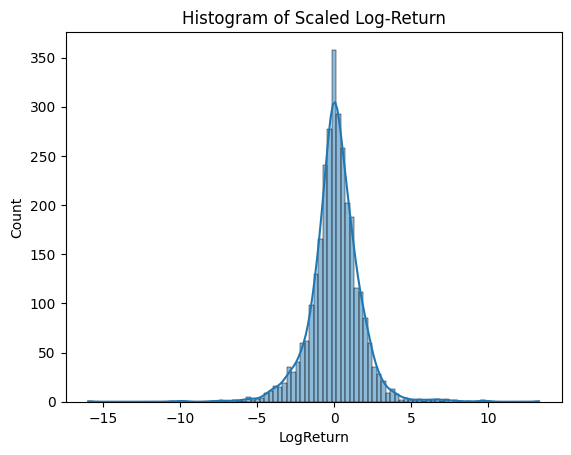

In [14]:
sns.histplot(r_pct, bins=100, kde=True)
plt.title('Histogram of Scaled Log-Return')
plt.show()

R^2 metrics are meaningless in volatility modeling, they refer to mean equation which is 0 

In [15]:
models = pd.DataFrame(columns=['model', 'aic', 'bic', 'lik'])

params = [1, 2, 5, 10, 15]
progress = 0
# p and q - based on squared return ACF plot
for p, q in itertools.product(params, repeat=2):
    progress += 1
    arch_fit = arch_model(r_pct.values, mean="Zero", vol='ARCH', p=p, dist='normal').fit(disp='off')
    garch_fit = arch_model(r_pct.values, mean='Zero', vol='GARCH', p=p, q=q, dist='normal').fit(disp='off')
    
    models.loc[f'arch{p}'] = arch_fit, arch_fit.aic, arch_fit.bic, arch_fit.loglikelihood
    models.loc[f'g{q}arch{p}'] = garch_fit, garch_fit.aic, garch_fit.bic, garch_fit.loglikelihood
    
    print(f"\rProgress: {progress} out of {len(params)**2} done", end='')

Progress: 25 out of 25 done

In [16]:
print(f"best model wrt AIC: {models['aic'].idxmin()}, with score: {models['aic'].min()}")
print(f"best model wrt BIC: {models['bic'].idxmin()}, with score: {models['bic'].min()}")

best model wrt AIC: arch15, with score: 11210.093658385238
best model wrt BIC: g1arch1, with score: 11231.290234527207


In [17]:
models.sort_values(by='aic').head(5)

,model,aic,bic,lik
arch15,Zero Mean - ARCH Model...,11210.093658,11306.470497,-5589.046829
g1arch15,Zero Mean - GARCH Model...,11212.093658,11314.494049,-5589.046829
g1arch1,Zero Mean - GARCH Model...,11213.219577,11231.290235,-5603.609789
g2arch15,Zero Mean - GARCH Model...,11214.093659,11322.517602,-5589.046829
g10arch5,Zero Mean - GARCH Model...,11214.680070,11311.056909,-5591.340035


In [18]:
models.sort_values(by='bic').head(5)

,model,aic,bic,lik
g1arch1,Zero Mean - GARCH Model...,11213.219577,11231.290235,-5603.609789
g1arch2,Zero Mean - GARCH Model...,11214.981190,11239.075399,-5603.490595
g2arch1,Zero Mean - GARCH Model...,11215.219577,11239.313787,-5603.609789
g2arch2,Zero Mean - GARCH Model...,11216.909635,11247.027397,-5603.454817
g1arch5,Zero Mean - GARCH Model...,11219.569467,11261.734334,-5602.784734


The ACF plot suggested long memory, however GARCH(1,1) == short lag giving a very contrained shape fit. Loglikehood of returns given the model-fit suggest that GARCH(1,1) is even worse than others.

ARCH(15) == high lag with highest AIC probably be an overfitting the training data.

The log likehood of arch(15) and GARCH(15, 1) is same, suggesting lagged variance parameter isn't doing anything. even the GARCH(1,1) and ARCH(15)

#### New insight: GARCH(1, 1) = ARCH(inf.) in geometric decaying weights(coeff). => the variance feedback recursively carries shocks into all future periods.

In [19]:
# rolling forecasting
rolling_pred = []
duration = 252*2 # 2 years

for day in range(0, duration):
    train = r_pct[:-(duration-day)]
    arch_fit = arch_model(train, p=15).fit(disp='off')
    
    pred_stats = arch_fit.forecast(horizon=TARGET)
    pred_var = pred_stats.variance.iloc[-1, 0]
    pred_vol = np.sqrt(pred_var + 0) # 0 mean
    rolling_pred.append(pred_vol)
    print(f'\r done {day}/{duration}', end='')
    
rolling_pred = pd.Series(rolling_pred, index=r_pct.index[-duration:])

 done 503/504

In [20]:
# rolling forecasting
rolling_pred_g = []
duration = 252*2 # 2 years

for day in range(duration):
    train = r_pct[:-(duration-day)]
    arch_fit = arch_model(train, p=1, q=1).fit(disp='off')
    
    pred_stats = arch_fit.forecast(horizon=TARGET)
    pred_var = pred_stats.variance.iloc[-1, 0]
    pred_vol = np.sqrt(pred_var + 0) # 0 mean
    rolling_pred_g.append(pred_vol)
    print(f'\r done {day}/{duration}', end='')
    
rolling_pred_g = pd.Series(rolling_pred_g, index=r_pct.index[-duration:])

 done 503/504

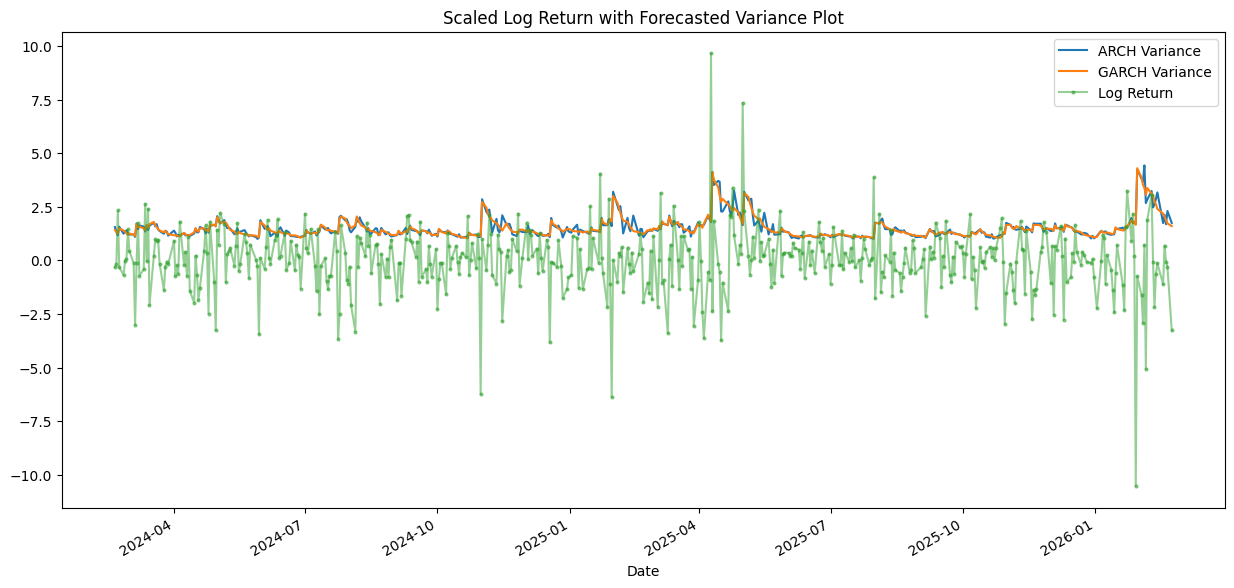

In [33]:
plt.figure(figsize=(15, 7))
rolling_pred.plot(label="ARCH Variance")
rolling_pred_g.plot(label="GARCH Variance")
r_pct[-duration:].plot(alpha=0.5, label="Log Return", marker='o', markersize=2)
plt.title("Scaled Log Return with Forecasted Variance Plot")
plt.legend()
plt.show()

One-off shock: ~ late Jan / early Feb 2026

Major burst: ~ March–April 2025

Minor burst: ~ Nov–Dec 2024

(G)ARCH is not capable of capturing single-day extreme spikes.

In [22]:
print(f"Excess Kurtosis: {r_pct.kurtosis()}")

Excess Kurtosis: 8.364213679995892


The log-return have high kurtosis, suggesting fat tailed distributed. 

The fat tails is likely goverened by COVID-19 (e.g., large and rare event) influence parameter estimates and volatility dynamics.

Next steps:

* Try GARCH with Student-t errors - can capture extreme spikes.

* Test asymmetric models (GJR-GARCH / EGARCH).

* Compare out-of-sample, pre-covid, post-covid sample.

* Test  shift regimes as volatility processes often breaks

For now, focus on modeling returns; later extend to risk measures (VaR, Expected Shortfall) and forecasting performance evaluation.

In [ ]:
# rolling volatility forecast using GARCH with student t-error
arch_model(train, p=1, q=1, vol='GARCH', dist='studentst')

In [53]:
# flexible 
@dataclass
class ModelSpec:
    # default model params
    p: int = 1
    vol: str = 'ARCH'
    # additional user defined param
    def to_kwargs(self):
        return asdict(self)

def rolling_vol(returns=r_pct, duration=duration, **kwargs):
    spec = ModelSpec()
    model_params = {**spec.to_kwargs(), **kwargs}
    pred_vol_list = []
    
    for day in range(duration):
        train = returns[:-(duration-day)]
        model_fit = arch_model(train, **model_params).fit(disp='off')
        pred_stats = model_fit.forecast(horizon=TARGET)

        pred_var = pred_stats.variance.iloc[-1, 0]
        pred_vol = np.sqrt(pred_var)
        pred_vol_list.append(pred_vol)
        print(f"\rDone {day+1}/{duration}", end="")
        
    pred_vol_list = pd.Series(pred_vol_list, index=returns.index[-duration:])
    return pred_vol_list

In [60]:
rolling_pred_garch_t = rolling_vol(duration=252*2, vol='GARCH', p=1, q=1, dist='studentst')

Done 504/504

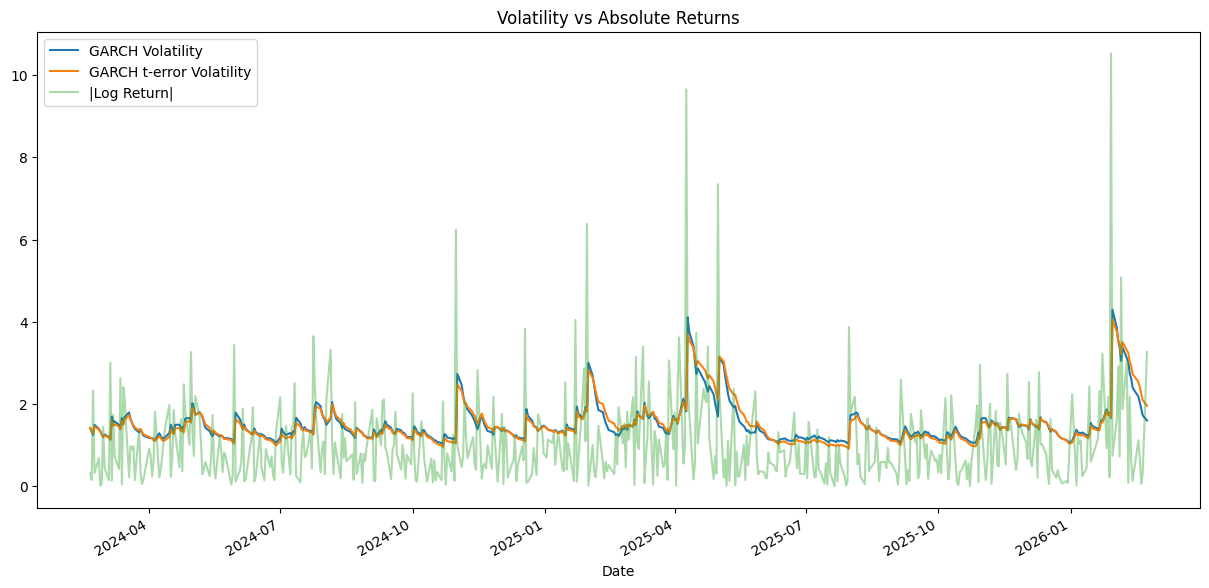

In [61]:
plt.figure(figsize=(15,7))

rolling_pred_g.plot(label="GARCH Volatility")
rolling_pred_garch_t.plot(label="GARCH t-error Volatility")
r_pct[-duration:].abs().plot(alpha=0.4, label="|Log Return|")

plt.title("Volatility vs Absolute Returns")
plt.legend()
plt.show()